## Generating Survey
### Sampling the real dataset of chemical reactions:

In [ ]:
import pandas as pd
import os
import numpy as np
import sentencepiece as spm


def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(
        r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "")
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


def prepare_whole_reaction_padded(df):
    df["full_input_format_delimited"] = "[BOS]" + \
        df["reactants"]+">>"+df["products"]+"[EOS]"
    df["full_input_format_delimited"] = df["full_input_format_delimited"].str.replace(
        " ", "")
    df["full_input_format"] = df["reactants"].str.replace(
        " ", "")+">>"+df["products"].str.replace(" ", "")


def tokenize_and_pad(df, max_len=0):
    # choose to set the max_len based on a user entered value or the one derived from the data
    if max_len == 0:
        max_val = df["input_ids"].str.len().sort_values(
            ascending=False).head(1).values[0]
        print(max_val)
        return
    else:
        max_val = max_len
    # Create the encoded columns
    df["input_ids"] = df["full_input_format_delimited"].apply(
        sp.encode_as_ids).apply(lambda x: x[1:])
    df_new = df[df["input_ids"].apply(len) <= max_val].copy()
    print("removed ", df.shape[0]-df_new.shape[0], " samples")

    # calculate how much to pad for each case
    df_new["input_counts"] = max_val-df_new["input_ids"].str.len()

    # pad with the PAD_TOKEN
    df_new["input_ids"] = df_new.apply(lambda row: np.pad(
        row["input_ids"], (0, row["input_counts"]), mode='constant', constant_values=(0, PAD_TOKEN)), axis=1)

    return np.asarray(df_new["input_ids"].values.tolist()), max_val, df_new


data_path = os.path.join("Liu_Kheyer_Retrosynthesis_Data")
train_path = os.path.join(data_path, "train")
train_reactants_df = pd.read_csv(os.path.join(
    train_path, "train_targets.txt"), header=None)
train_products_df = pd.read_csv(os.path.join(
    train_path, "train_sources.txt"), header=None)
df = process_dfs(train_reactants_df, train_products_df)
rxns = df["reaction_type"].value_counts(ascending=False)/df.shape[0]
prepare_whole_reaction_padded(df)
spt_1 = spm.SentencePieceTrainer.train(
    "--input=vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1")
sp = spm.SentencePieceProcessor()
sp.load('m.model')
PAD_TOKEN = sp.encode_as_ids("[PAD]")[1]
BOS_TOKEN = sp.encode_as_ids("[BOS]")[1]
train_inputs, train_input_len, df_with_max_200 = tokenize_and_pad(df, 200)
df_with_max_200["input_ids"].str.len().sort_values()

In [ ]:
file = open("real_samples.txt", "w+")
classes = df_with_max_200["reaction_type"].value_counts().index
for rxn in classes:
    arr = df_with_max_200.loc[df_with_max_200["reaction_type"] == str(
        rxn), "full_input_format"].sample(n=2, random_state=42).values
    file.write(str(rxn)+"\n")
    for el in arr:
        file.write(el+"\n")
file.close()
sampled_df = pd.read_csv("/content/mixed_samples.csv", index_col=0)
sampled_df
classes = df_with_max_200["reaction_type"].value_counts().index
for rxn in classes:
    sampled = df_with_max_200.loc[df_with_max_200["reaction_type"] ==
                                  rxn, "full_input_format"].sample(n=1, random_state=42).values
    for el in sampled:
        sampled_df = sampled_df.append(
            {"reaction": rxn+str(el), "version": "v0", "type": "real"}, ignore_index=True)
print(sampled_df)

### Sampling the fake dataset of chemical reactions:

In [ ]:
from generate import VAEGenerator
from eval import generate_metrics_evaluation
import json
import torch
import numpy as np
import random

with open("config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}

config["cuda"] = not config["no_cuda"] and torch.cuda.is_available()

# fix seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])

if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

vae_generator = VAEGenerator(config)
vae_generator.generate_samples()

gene_file = os.path.join(train_path, "v4", "gene.data")
with open(os.path.join(train_path, "centroids_200.data"), "r", encoding='utf-8') as f:
    centroids = np.loadtxt(f)
with open(os.path.join(train_path, "centroids_strings_200.data"), "r", encoding='utf-8') as f:
    centroids_strings = np.loadtxt(f)

jsd, avg_similarity, avg_str_similarity, valid, filter0, filter2, filter4, filter5, validated, exact_perc, duplicates_perc, vendi_score_k, vendi_score_k_inf, vendi_score_k_small, average_inter_similarity, avg_vs_score_per_class, df, div_class_df, rxn_pred, sims, gen_fingerprints = generate_metrics_evaluation(
    gene_file, centroids, centroids_strings, tokenizer=sp, main_path=data_path, seq_len=200, data_ref_path="train_ref_dataset.csv")
df_best_valid = df[df["isValid"]].copy()
df_best_valid["reaction_type"] = rxn_pred

In [ ]:
file = open("fake_samples.txt", "w+")
classes = df_best_valid["reaction_type"].value_counts().index
for rxn in classes:
    arr = df_best_valid.loc[df_best_valid["reaction_type"] ==
                            rxn, "decoded_smiles"].sample(n=2, random_state=42).values
    file.write("<RX"+str(rxn+1)+">"+"\n")
    for el in arr:
        file.write(el+"\n")
file.close()

## Evaluating Survey

In [ ]:
"""
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit=2020.09.02
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
"""
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 13.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
origin = pd.read_csv("/content/mixed_samples-final.csv")
reactions = origin["reaction"].str.replace(r"<RX_?\d+>", "", regex=True)
origin["reaction_mod"] = origin["reaction"].str.replace(
    r"<RX_?\d+>", "", regex=True)
survey = pd.read_csv(
    "/content/Investigating the Quality of AI-generated Chemical Reactions.csv")
print("Received %d responses" % (survey.shape[0]))

Received 7 responses


In [ ]:
valid_results = pd.DataFrame()
valid_results["reaction_mod"] = reactions
for rxn in reactions:
    for i, col in enumerate(survey.columns):
        if rxn == col:
            results = survey.iloc[:, i+2]
            res = results.value_counts()
    for key in res.index:
        valid_results.loc[valid_results["reaction_mod"] == rxn, key] = res[key]
valid_results.fillna(0, inplace=True)

gen_results = pd.DataFrame()
gen_results["reaction_mod"] = reactions
for rxn in reactions:
    results = survey[rxn]
    res = results.value_counts()
    for key in res.index:
        gen_results.loc[gen_results["reaction_mod"] == rxn, key] = res[key]
gen_results.fillna(0, inplace=True)

In [ ]:
"""
merged_a=pd.merge(origin,valid_results,on="reaction_mod")
valid_df=pd.DataFrame()
valid_df["version"]=np.unique(merged_a["version"])
for i,v in enumerate(np.unique(merged_a["version"])):
  merged_v=merged_a[merged_a["version"]==v]
  valid_df.loc[i,"Invalid"]=merged_v["Invalid"].sum()/(merged_v.shape[0]*survey.shape[0])
  valid_df.loc[i,"Valid"]=merged_v["Valid"].sum()/(merged_v.shape[0]*survey.shape[0])

merged=pd.merge(origin,gen_results,on="reaction_mod")
turing_df=pd.DataFrame()
turing_df["version"]=np.unique(merged["version"])
for i,v in enumerate(np.unique(merged["version"])):
  merged_v=merged[merged["version"]==v]
  turing_df.loc[i,"Human-generated"]=merged_v["Human-generated"].sum()/(merged_v.shape[0]*survey.shape[0])
  turing_df.loc[i,"Machine-generated"]=merged_v["Machine-generated"].sum()/(merged_v.shape[0]*survey.shape[0])
pd.merge(valid_df,turing_df)
"""

In [ ]:
joined.groupby("version").sum()[
    ['Invalid', 'Valid', 'Human-generated', 'Machine-generated']]/(10*survey.shape[0])

,Invalid,Valid,Human-generated,Machine-generated
version,,,,
v0,0.171429,0.828571,0.771429,0.228571
v2.4,0.657143,0.342857,0.371429,0.628571
v4,0.600000,0.385714,0.442857,0.557143
v4.2,0.757143,0.242857,0.342857,0.657143


In [ ]:
joined = origin[["version", "reaction_mod"]].set_index("reaction_mod").join(
    valid_results.set_index("reaction_mod")).join(gen_results.set_index("reaction_mod")).reset_index()
joined["Valid_perc"] = joined["Valid"]/(joined["Valid"]+joined["Invalid"])
joined[joined["version"] != "v0"].sort_values("Valid_perc", ascending=False)

,reaction_mod,version,Invalid,Valid,Machine-generated,Human-generated,Valid_perc
4,COC(=O)c1ccc(Cl)nc1>>OCc1ccc(Cl)nc1,v2.4,0.0,7.0,2.0,5.0,1.000000
6,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CN1CCC(N)CC1>>CN...,v2.4,0.0,7.0,2.0,5.0,1.000000
22,CC(C)(C)OC(=O)COc1ccc(B(O)O)cc1.Oc1ccc(Br)nc1>...,v4,1.0,5.0,1.0,6.0,0.833333
14,O=C1NCCc2cc([N+](=O)[O-])ccc21>>Nc1ccc2c(c1)CC...,v4.2,2.0,5.0,3.0,4.0,0.714286
23,CC(C)(C)N.N#Cc1cc(Cl)cc(S(=O)(=O)Cl)c1>>CC(C)(...,v4,2.0,5.0,3.0,4.0,0.714286
26,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Oc1cccc(Cl)c1S>>...,v4,3.0,4.0,2.0,5.0,0.571429
20,COc1cc(C=O)ccc1O.O=C1CCCC1>>COc1cc(C=O)ccc1OC1...,v4,3.0,4.0,1.0,6.0,0.571429
28,COC(=O)c1c(C(F)F)ccnc1C(F)(F)F>>COC(=O)c1c(C(F...,v4,4.0,3.0,6.0,1.0,0.428571
3,Clc1cccc(CN2CCNCC2)c1.O=C([O-])O>>O=Cc1cccc(N2...,v2.4,4.0,3.0,6.0,1.0,0.428571
5,CNC(=O)c1ccc(C(=O)OC)cc1>>CNC(=O)c1ccc(C#N)cc1,v2.4,4.0,3.0,5.0,2.0,0.428571


## Sampling for Reactions from Version 4

In [ ]:
joined[(joined["Valid_perc"] > 0.5) & (joined["version"] == "v4")]

,reaction_mod,version,Invalid,Valid,Machine-generated,Human-generated,Valid_perc
20,COc1cc(C=O)ccc1O.O=C1CCCC1>>COc1cc(C=O)ccc1OC1...,v4,3.0,4.0,1.0,6.0,0.571429
22,CC(C)(C)OC(=O)COc1ccc(B(O)O)cc1.Oc1ccc(Br)nc1>...,v4,1.0,5.0,1.0,6.0,0.833333
23,CC(C)(C)N.N#Cc1cc(Cl)cc(S(=O)(=O)Cl)c1>>CC(C)(...,v4,2.0,5.0,3.0,4.0,0.714286
26,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Oc1cccc(Cl)c1S>>...,v4,3.0,4.0,2.0,5.0,0.571429


In [ ]:
v4_valid = joined[(joined["Valid_perc"] > 0.5) & (
    joined["version"] == "v4")].reaction_mod.tolist()
v4_valid

['COc1cc(C=O)ccc1O.O=C1CCCC1>>COc1cc(C=O)ccc1OC1CCCC1',
 'CC(C)(C)OC(=O)COc1ccc(B(O)O)cc1.Oc1ccc(Br)nc1>>CC(C)(C)OC(=O)COc1ccc(-c2ccc(O)cn2)cc1',
 'CC(C)(C)N.N#Cc1cc(Cl)cc(S(=O)(=O)Cl)c1>>CC(C)(C)S(=O)c1cc(Cl)cc(C#N)c1',
 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Oc1cccc(Cl)c1S>>CC(C)(C)OC(=O)COc1cccc(Cl)c1S']

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdChemReactions
molsMatrix = []
for rxn in v4_valid:
    molsMatrix.append(rdChemReactions.ReactionFromSmarts(rxn))

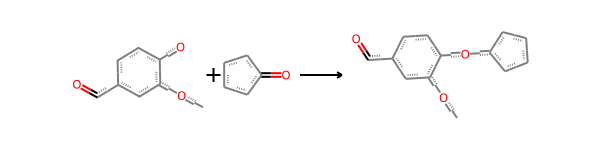

In [ ]:
molsMatrix[0]

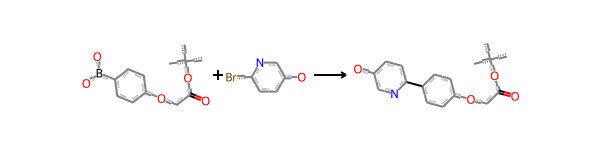

In [ ]:
molsMatrix[1]

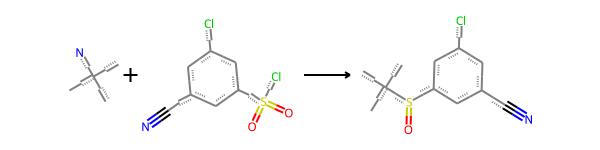

In [ ]:
molsMatrix[2]

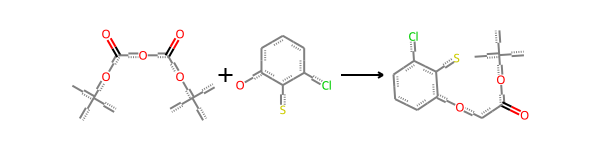

In [ ]:
molsMatrix[3]

## Sampling for Reactions from Version 2.4

In [ ]:
joined[(joined["Valid_perc"] > 0.5) & (joined["version"] == "v2.4")]

,reaction_mod,version,Invalid,Valid,Machine-generated,Human-generated,Valid_perc
4,COC(=O)c1ccc(Cl)nc1>>OCc1ccc(Cl)nc1,v2.4,0.0,7.0,2.0,5.0,1.0
6,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CN1CCC(N)CC1>>CN...,v2.4,0.0,7.0,2.0,5.0,1.0


In [ ]:
v24_valid = joined[(joined["Valid_perc"] > 0.5) & (
    joined["version"] == "v2.4")].reaction_mod.tolist()
v24_valid

['COC(=O)c1ccc(Cl)nc1>>OCc1ccc(Cl)nc1',
 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CN1CCC(N)CC1>>CN1CCC(NC(=O)OC(C)(C)C)CC1']

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdChemReactions
molsMatrix = []
for rxn in v24_valid:
    molsMatrix.append(rdChemReactions.ReactionFromSmarts(rxn))

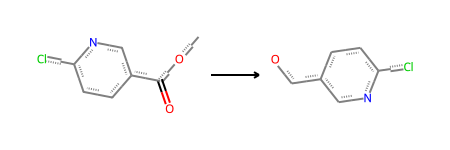

In [ ]:
molsMatrix[0]

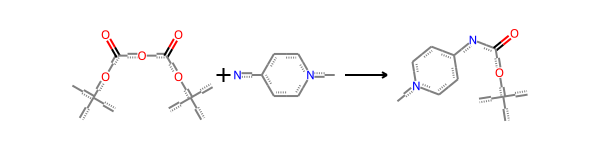

In [ ]:
molsMatrix[1]

## Sampling for Reactions from Version 4.2

In [ ]:
joined[(joined["Valid_perc"] > 0.5) & (joined["version"] == "v4.2")]

,reaction_mod,version,Invalid,Valid,Machine-generated,Human-generated,Valid_perc
14,O=C1NCCc2cc([N+](=O)[O-])ccc21>>Nc1ccc2c(c1)CC...,v4.2,2.0,5.0,3.0,4.0,0.714286


In [ ]:
v42_valid = joined[(joined["Valid_perc"] > 0.5) & (
    joined["version"] == "v4.2")].reaction_mod.tolist()
v42_valid

['O=C1NCCc2cc([N+](=O)[O-])ccc21>>Nc1ccc2c(c1)CCN=C2']

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import rdChemReactions
molsMatrix = []
for rxn in v42_valid:
    molsMatrix.append(rdChemReactions.ReactionFromSmarts(rxn))

In [ ]:
molsMatrix[0]